In [1]:
#from __future__ import print_function
import sys, json, os, re
import subprocess
import multiprocessing as mp
import numpy as np
from array import array
import tarfile
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
from ROOT import gROOT, gStyle, gDirectory, gPad

import constants
import crv_event
import crv_spill
import utils
import root_utils
import geometry
import geometry_constants
import filepath

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")

#''' # running on gpvm
# preparation of environment 
os.system("setup mu2efiletools")
os.system("setup dhtools")
# get files 
cmd = "mu2eDatasetFileList etc.mu2e.CRV_wideband_cosmics.crviv-000.tgz"
buffer = subprocess.check_output(cmd, shell=True, text=True)
file_list = [f for f in buffer.split('\n') if f.strip()]
#''' # running on gpvm

''' # running on EAC, static file_list declaration
file_list = ['/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/a2/4f/etc.mu2e.CRV_wideband_cosmics.crviv-000.000000_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/13/e3/etc.mu2e.CRV_wideband_cosmics.crviv-000.000005_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/42/d9/etc.mu2e.CRV_wideband_cosmics.crviv-000.000010_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/2f/f5/etc.mu2e.CRV_wideband_cosmics.crviv-000.000015_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/3e/a0/etc.mu2e.CRV_wideband_cosmics.crviv-000.000020_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/12/a9/etc.mu2e.CRV_wideband_cosmics.crviv-000.000025_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/02/6c/etc.mu2e.CRV_wideband_cosmics.crviv-000.000025_001.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/de/2d/etc.mu2e.CRV_wideband_cosmics.crviv-000.000030_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/b4/8f/etc.mu2e.CRV_wideband_cosmics.crviv-000.000035_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/57/aa/etc.mu2e.CRV_wideband_cosmics.crviv-000.000035_001.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/d8/73/etc.mu2e.CRV_wideband_cosmics.crviv-000.000040_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/a8/16/etc.mu2e.CRV_wideband_cosmics.crviv-000.004086_000.tgz',
             '/pnfs/mu2e/tape/phy-etc/etc/mu2e/CRV_wideband_cosmics/crviv-000/tgz/39/b4/etc.mu2e.CRV_wideband_cosmics.crviv-000.004091_000.tgz']
''' # running on EAC, static file_list declaration

def ivNameParser(fullfilename, item):
    localFilename = fullfilename.split('/')[-1]
    buffer = re.split('\.|_',localFilename)
    temp = buffer[6].lstrip("0")
    temp = float(temp) if temp else 0.
    temp = temp if temp < 100. else temp-4096.
    subset = int(buffer[7])
    if item == 'subset':
        return subset
    elif item == 'temp':
        return temp
    else:
        print(item, "is not a valid attribute name of filename.")
        return None
    
file_list.sort(key=lambda x:(ivNameParser(x,'temp'), ivNameParser(x,'subset')))

Welcome to JupyROOT 6.28/04


In [2]:
def getVbd(df, debug = False):
    # Define the parabolic function
    def par_func(x, a, b, c):
        return a * x**2 + b * x + c
    # Define the linear function
    def lin_func(x, a, b):
        return a * x + b

    x=df.V.to_numpy()
    y=df.I_log.to_numpy()
    if debug:
        plt.figure()
        plt.plot(x, y, '-')

    Vbr = df['Vbr'].iloc[0]
    x_ = df.query('V>%f & V<%f'%(Vbr-0.1, Vbr+0.5)).V
    y_ = df.query('V>%f & V<%f'%(Vbr-0.1, Vbr+0.5)).I_log

    popt_par, pcov = curve_fit(par_func, x_, y_)
    if debug:
        plt.plot(x, par_func(x, *popt_par), 'r-')

    x_ = df.query('V<%f'%(Vbr-0.25)).V
    y_ = df.query('V<%f'%(Vbr-0.25)).I_log
    popt_lin, pcov = curve_fit(lin_func, x_, y_)
    if debug:
        plt.plot(x_, lin_func(x_, *popt_lin), 'r-')

    # finex = np.arange(x.min(), x.max(), 0.01)
    finex = np.arange(x.min(), Vbr+2., 0.01) # changed range
    f_par = par_func(finex, *popt_par)
    f_lin = lin_func(finex, *popt_lin)

    idx = np.argwhere(np.diff(np.sign(f_par - f_lin))).flatten()
    if idx.size == 0:
        print("Failed Vbd extraction, ")
        print(popt_par)
        print(popt_lin)
        return np.nan
    else:
        return finex[idx[0]].item() # need to only take the first cross point

df = pd.DataFrame()

for file in file_list:
    Temp = ivNameParser(file,'temp')
    subset = ivNameParser(file,'subset')

    with tarfile.open(file, 'r:gz') as tar:
        # Iterate over the files in the archive
        for member in tar.getmembers():
            # Extract the file
            if member.isdir():
                continue
            file = tar.extractfile(member)
            basename = os.path.basename(member.name)
            print(Temp, subset, basename)
            # Load the extracted file into a pandas DataFrame
            df_ = pd.read_csv(file, skiprows=8, header=0, names = ["V", "I"])  # Assuming the file is in CSV format            
            
            # Get rid of the funky extra data point at the end of the scan
            
            if df_['V'].iloc[-1]<df_['V'].iloc[-2]:
                df_.drop(index=df_.index[-1],axis=0,inplace=True)
            
            split_name = basename.split("_")
            fpga = int(split_name[2][4:])
            chan = int(split_name[3][2:])
            df_['fpga'] = fpga
            df_['chan'] = chan + 16*fpga
            df_['I_log'] = np.log(df_['I'])            
            if (df_['I']<=0).any():
                print(Temp, subset, basename)
                display(df_[['I', 'I_log']])
            df_['Temp_nominal'] = Temp
            df_['subset'] = subset
            # Calculate dLog(I)/dV to estimate the breakdown voltage
            df_coarse = df_.groupby(df_.index // 4).mean()
            df_['Vbr'] = df_coarse['V'][df_coarse['I_log'].diff().idxmax()]
            # df_['Vbr_fit'] = getVbd(df_, True)
            df = pd.concat([df,df_], ignore_index=True)


-10.0 0 IV_FEB0_FPGA0_ch0_20230728_145337.IV
-10.0 0 IV_FEB0_FPGA0_ch10_20230728_145319.IV
-10.0 0 IV_FEB0_FPGA0_ch11_20230728_145321.IV
-10.0 0 IV_FEB0_FPGA0_ch12_20230728_145324.IV
-10.0 0 IV_FEB0_FPGA0_ch13_20230728_145327.IV
-10.0 0 IV_FEB0_FPGA0_ch14_20230728_145330.IV
-10.0 0 IV_FEB0_FPGA0_ch15_20230728_145332.IV
-10.0 0 IV_FEB0_FPGA0_ch1_20230728_145254.IV
-10.0 0 IV_FEB0_FPGA0_ch2_20230728_145257.IV
-10.0 0 IV_FEB0_FPGA0_ch3_20230728_145259.IV
-10.0 0 IV_FEB0_FPGA0_ch4_20230728_145302.IV
-10.0 0 IV_FEB0_FPGA0_ch5_20230728_145305.IV
-10.0 0 IV_FEB0_FPGA0_ch6_20230728_145307.IV
-10.0 0 IV_FEB0_FPGA0_ch7_20230728_145310.IV
-10.0 0 IV_FEB0_FPGA0_ch8_20230728_145313.IV
-10.0 0 IV_FEB0_FPGA0_ch9_20230728_145316.IV
-10.0 0 IV_FEB0_FPGA1_ch0_20230728_183710.IV
-10.0 0 IV_FEB0_FPGA1_ch10_20230728_183652.IV
-10.0 0 IV_FEB0_FPGA1_ch11_20230728_183655.IV
-10.0 0 IV_FEB0_FPGA1_ch12_20230728_183658.IV
-10.0 0 IV_FEB0_FPGA1_ch13_20230728_183700.IV
-10.0 0 IV_FEB0_FPGA1_ch14_20230728_183703.IV

/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


I     I_log
0     1.1  0.095310
1     1.2  0.182322
2     1.2  0.182322
3     0.4 -0.916291
4     0.5 -0.693147
..    ...       ...
94  209.9  5.346631
95  217.3  5.381279
96  229.6  5.436339
97  238.1  5.472691
98  247.8  5.512622

[99 rows x 2 columns]

25.0 1 IV_FEB0_FPGA0_ch10_20230714_164636.IV
25.0 1 IV_FEB0_FPGA0_ch11_20230714_164638.IV
25.0 1 IV_FEB0_FPGA0_ch11_20230714_164638.IV


/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


I     I_log
0     1.1  0.095310
1     0.8 -0.223144
2     2.1  0.741937
3     1.6  0.470004
4     0.4 -0.916291
..    ...       ...
95  226.1  5.420977
96  232.4  5.448460
97  240.0  5.480639
98  248.8  5.516649
99  258.2  5.553734

[100 rows x 2 columns]

25.0 1 IV_FEB0_FPGA0_ch12_20230714_164639.IV
25.0 1 IV_FEB0_FPGA0_ch13_20230714_164640.IV
25.0 1 IV_FEB0_FPGA0_ch14_20230714_164641.IV
25.0 1 IV_FEB0_FPGA0_ch15_20230714_164642.IV
25.0 1 IV_FEB0_FPGA0_ch15_20230714_164642.IV


/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


I     I_log
0     0.4 -0.916291
1     1.1  0.095310
2     0.9 -0.105361
3     0.4 -0.916291
4     0.8 -0.223144
..    ...       ...
95  229.1  5.434159
96  237.7  5.471009
97  246.1  5.505738
98  254.8  5.540479
99  262.4  5.569870

[100 rows x 2 columns]

25.0 1 IV_FEB0_FPGA0_ch1_20230714_164628.IV
25.0 1 IV_FEB0_FPGA0_ch2_20230714_164628.IV
25.0 1 IV_FEB0_FPGA0_ch2_20230714_164628.IV


/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


I     I_log
0     1.1  0.095310
1     1.6  0.470004
2     1.3  0.262364
3     1.6  0.470004
4     2.1  0.741937
..    ...       ...
95  241.8  5.488111
96  252.3  5.530619
97  262.9  5.571774
98  273.2  5.610204
99  282.3  5.642970

[100 rows x 2 columns]

25.0 1 IV_FEB0_FPGA0_ch3_20230714_164630.IV
25.0 1 IV_FEB0_FPGA0_ch4_20230714_164630.IV
25.0 1 IV_FEB0_FPGA0_ch5_20230714_164631.IV
25.0 1 IV_FEB0_FPGA0_ch6_20230714_164632.IV
25.0 1 IV_FEB0_FPGA0_ch7_20230714_164633.IV
25.0 1 IV_FEB0_FPGA0_ch8_20230714_164634.IV
25.0 1 IV_FEB0_FPGA0_ch8_20230714_164634.IV


/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


I     I_log
0     0.8 -0.223144
1     0.6 -0.510826
2     0.4 -0.916291
3     1.1  0.095310
4     1.0  0.000000
..    ...       ...
95  247.0  5.509388
96  253.2  5.534180
97  265.5  5.581615
98  273.7  5.612033
99  283.8  5.648270

[100 rows x 2 columns]

25.0 1 IV_FEB0_FPGA0_ch9_20230714_164635.IV
30.0 0 IV_FEB0_FPGA0_ch0_20230718_135829.IV
30.0 0 IV_FEB0_FPGA0_ch10_20230718_135811.IV
30.0 0 IV_FEB0_FPGA0_ch11_20230718_135814.IV
30.0 0 IV_FEB0_FPGA0_ch12_20230718_135817.IV
30.0 0 IV_FEB0_FPGA0_ch13_20230718_135820.IV
30.0 0 IV_FEB0_FPGA0_ch14_20230718_135823.IV
30.0 0 IV_FEB0_FPGA0_ch15_20230718_135825.IV
30.0 0 IV_FEB0_FPGA0_ch1_20230718_135747.IV
30.0 0 IV_FEB0_FPGA0_ch2_20230718_135749.IV
30.0 0 IV_FEB0_FPGA0_ch3_20230718_135752.IV
30.0 0 IV_FEB0_FPGA0_ch4_20230718_135755.IV
30.0 0 IV_FEB0_FPGA0_ch5_20230718_135758.IV
30.0 0 IV_FEB0_FPGA0_ch6_20230718_135800.IV
30.0 0 IV_FEB0_FPGA0_ch7_20230718_135803.IV
30.0 0 IV_FEB0_FPGA0_ch8_20230718_135806.IV
30.0 0 IV_FEB0_FPGA0_ch9_20230718_135809.IV
30.0 0 IV_FEB0_FPGA1_ch0_20230718_165529.IV
30.0 0 IV_FEB0_FPGA1_ch10_20230718_165511.IV
30.0 0 IV_FEB0_FPGA1_ch11_20230718_165514.IV
30.0 0 IV_FEB0_FPGA1_ch12_20230718_165516.IV
30.0 0 IV_FEB0_FPGA1_ch13_20230718_165519.IV
30.0 0 IV_FEB0_FPGA1_c

In [3]:
from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

df['rolling_slope'] = df.groupby("chan")['I'].rolling(window=15).apply(get_slope).reset_index(0, drop=True)

Text(0.5, 0, 'V [V]')

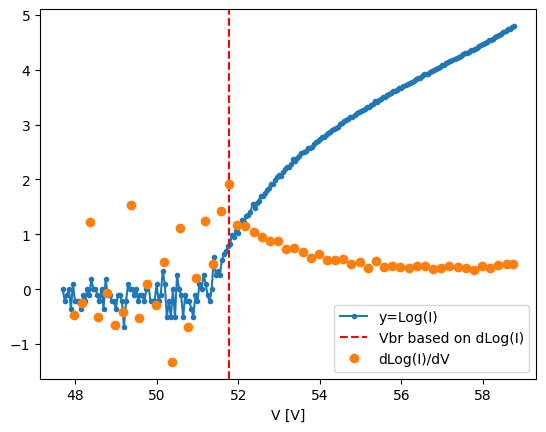

In [5]:
df1 = df.query("chan==6 & Temp_nominal==10. & subset==0").reset_index()
plt.plot(df1.V, df1.I_log, '.-', label='y=Log(I)');
plt.axvline(x=df1.Vbr[0], color='red', linestyle='--', label='Vbr based on dLog(I)')
#plt.axvline(x=df1.Vbr_fit[0], color='green', linestyle='-.', label='Vbr based on fit')

df_coarse = df1.groupby(df1.index // 4).mean()
plt.plot(df_coarse['V'], df_coarse['I_log'].diff()/df_coarse['V'].diff(), 'o', label='dLog(I)/dV')
plt.legend()
plt.xlabel("V [V]")

/tmp/ipykernel_6653/303110610.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


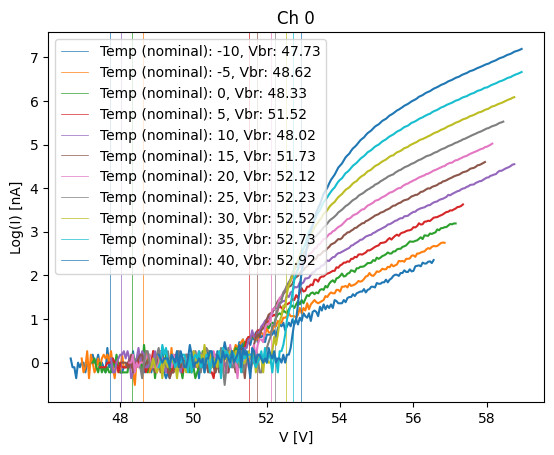

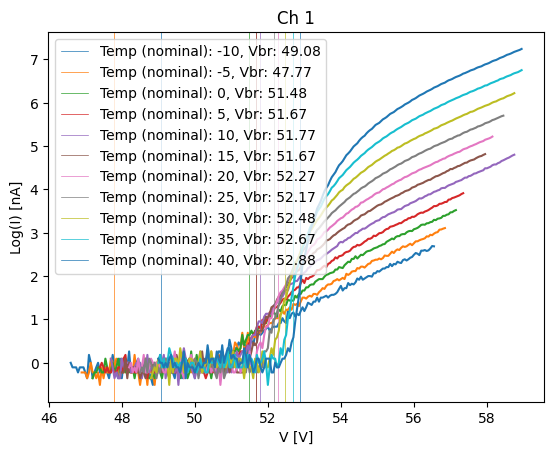

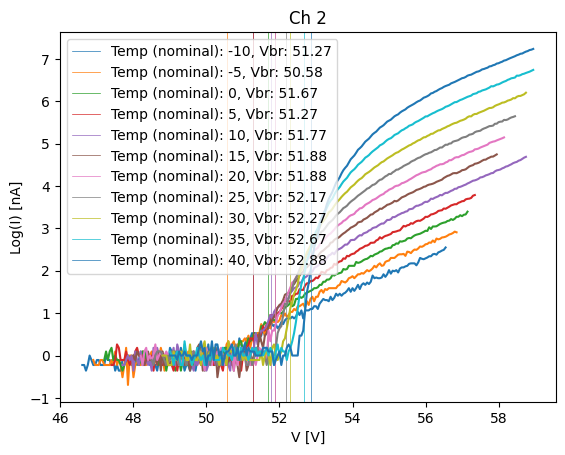

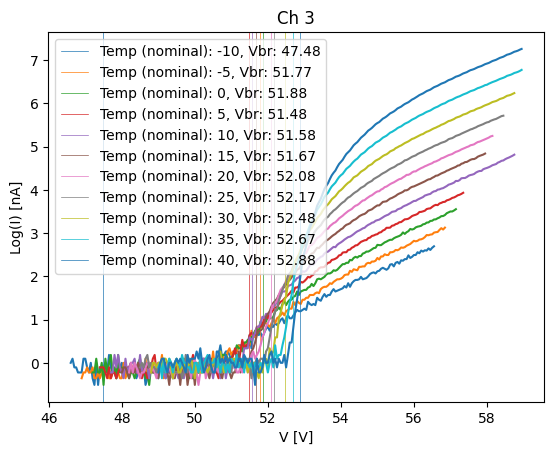

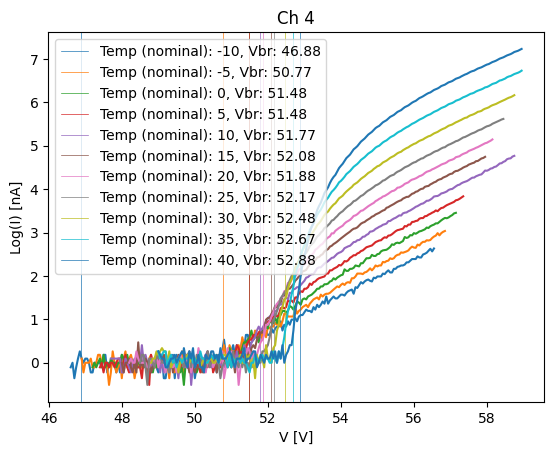

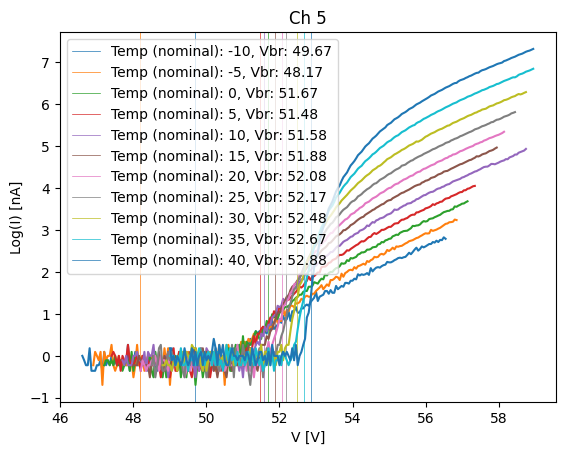

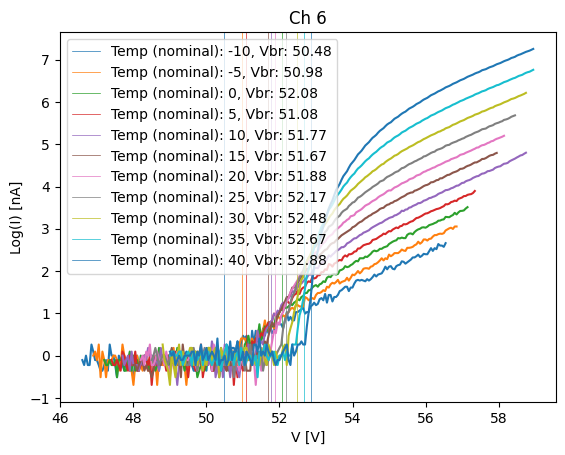

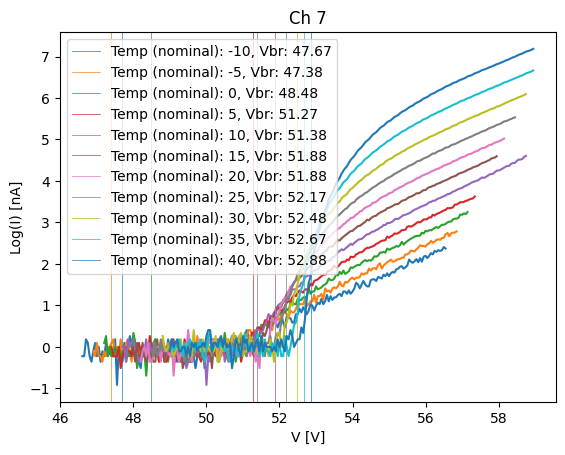

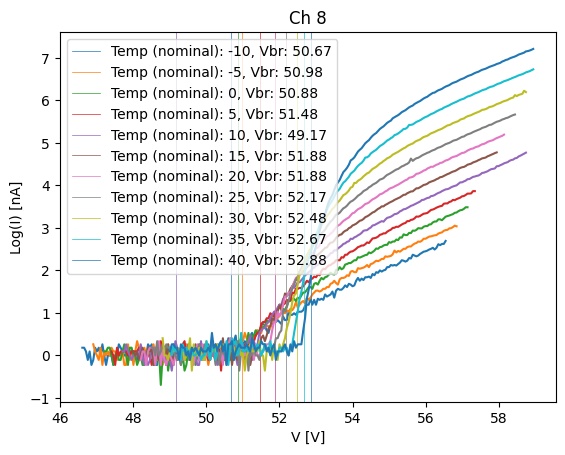

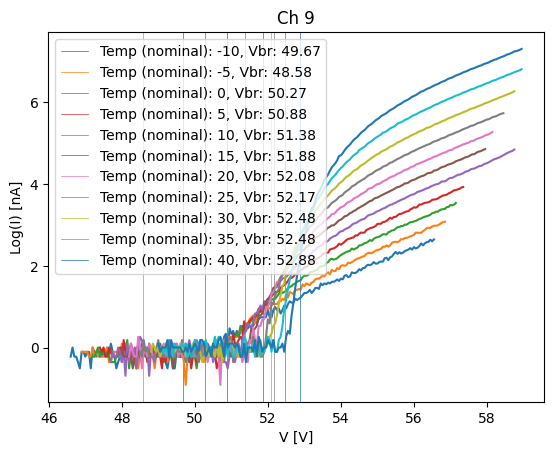

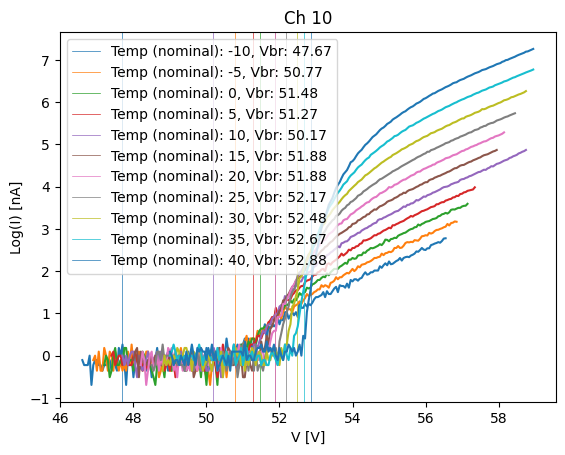

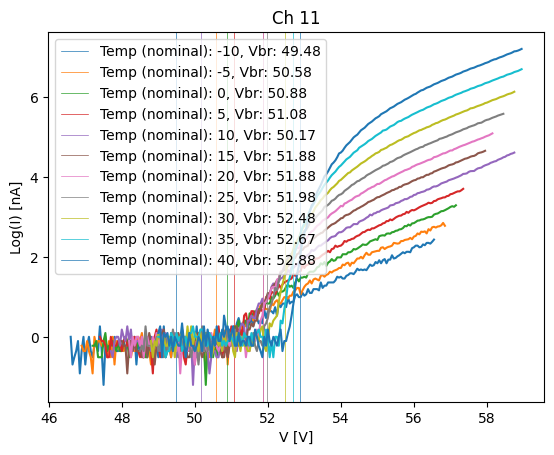

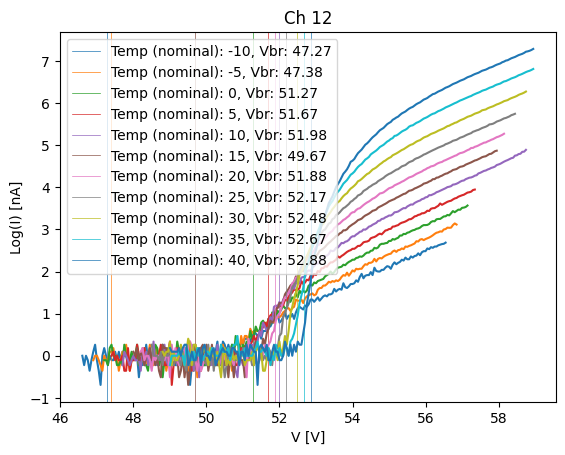

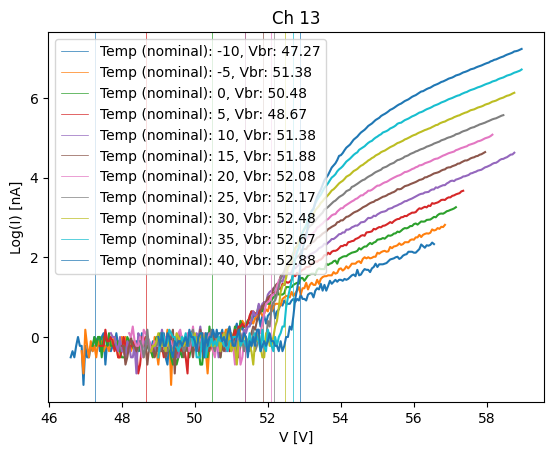

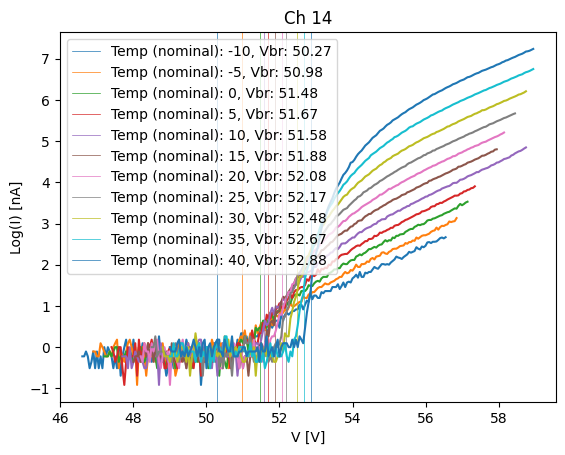

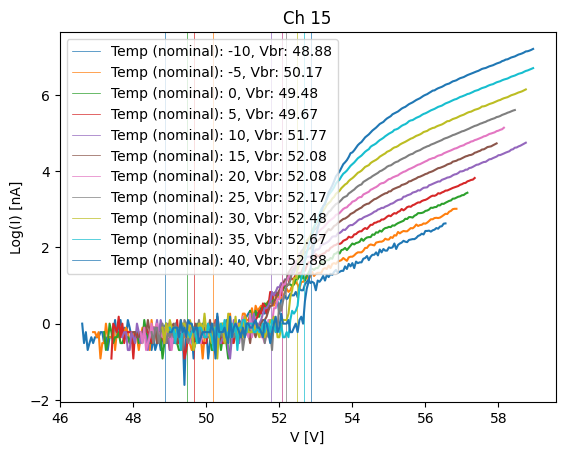

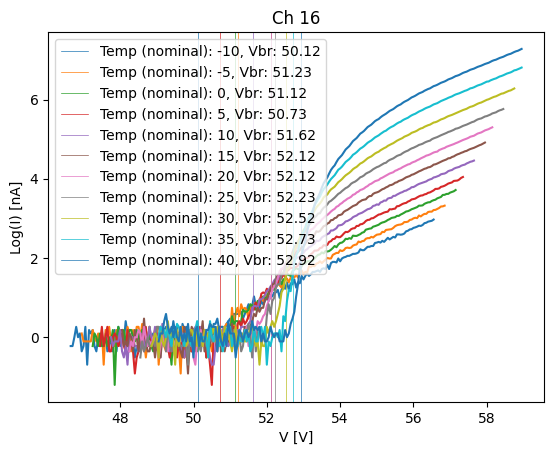

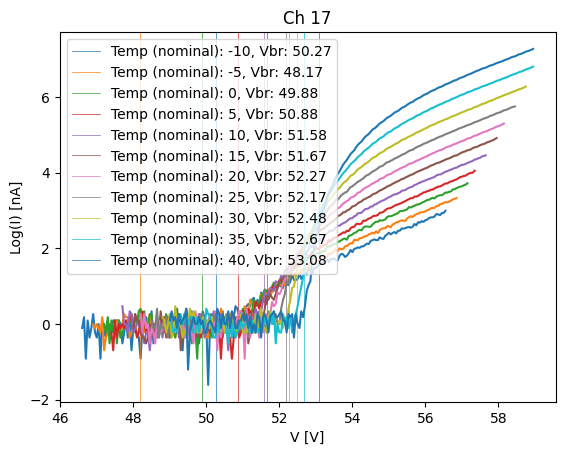

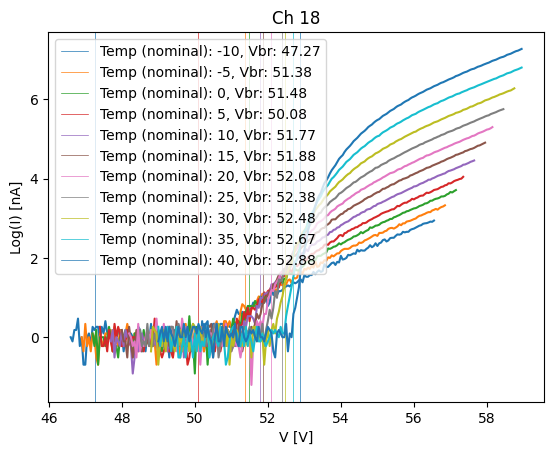

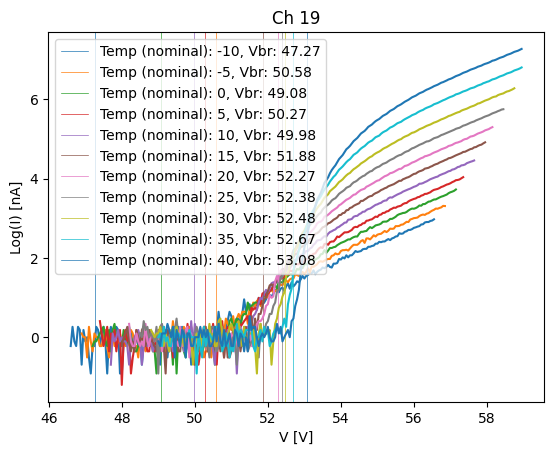

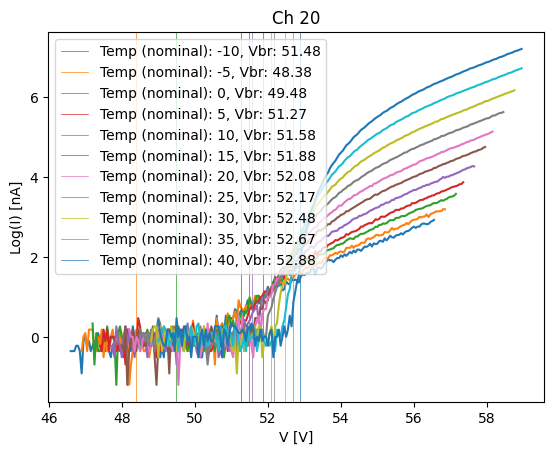

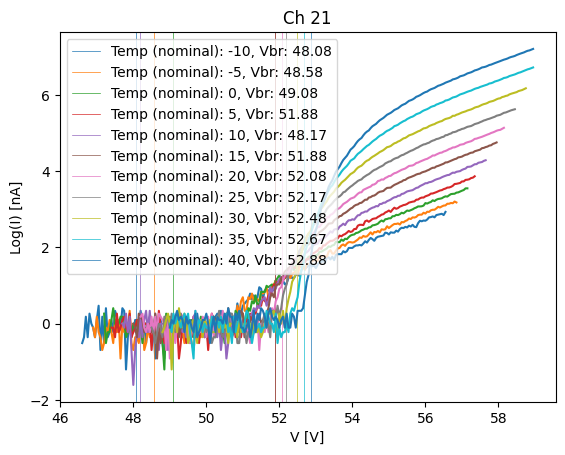

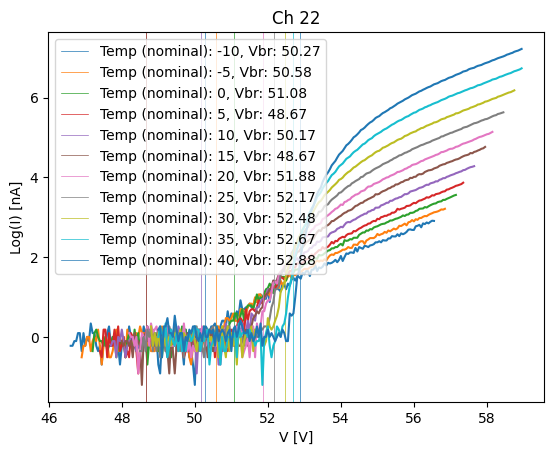

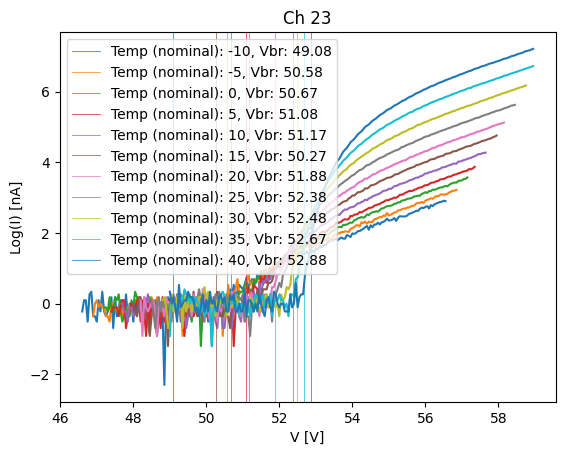

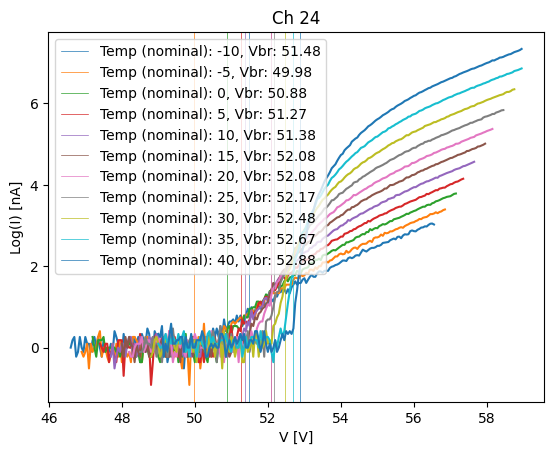

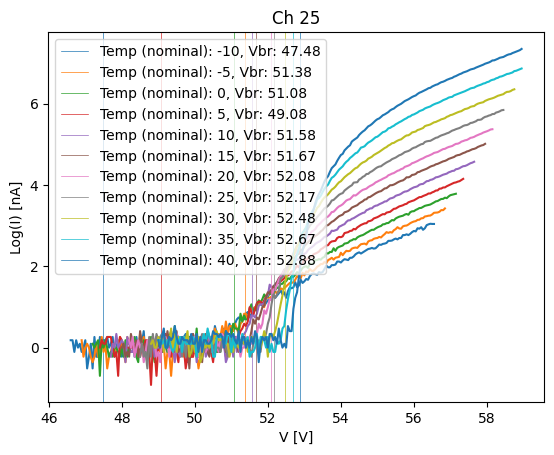

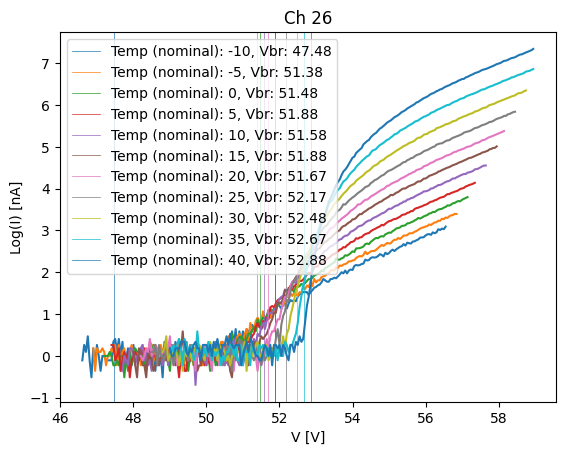

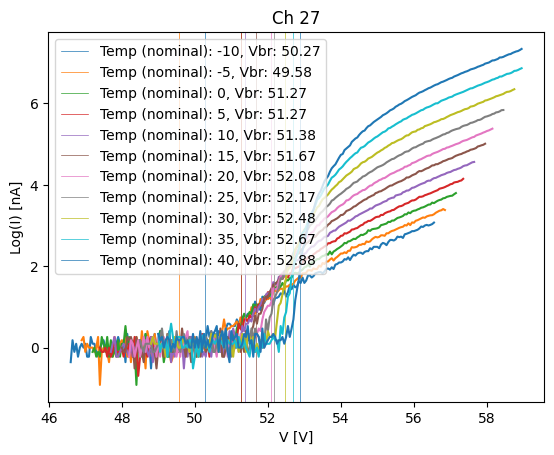

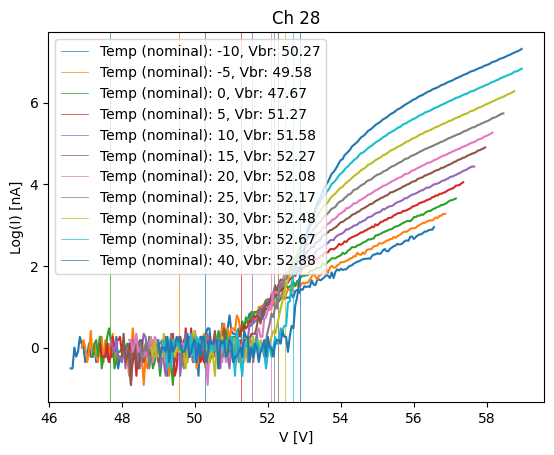

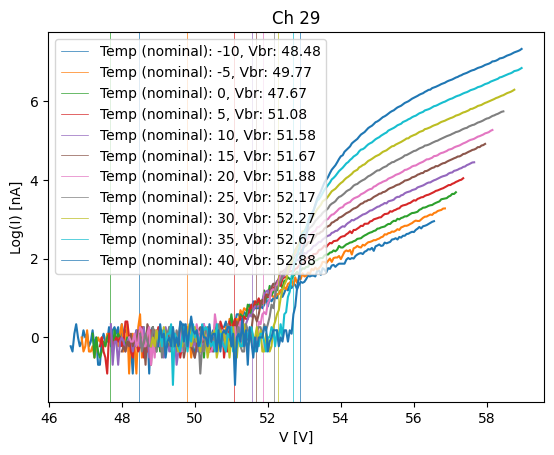

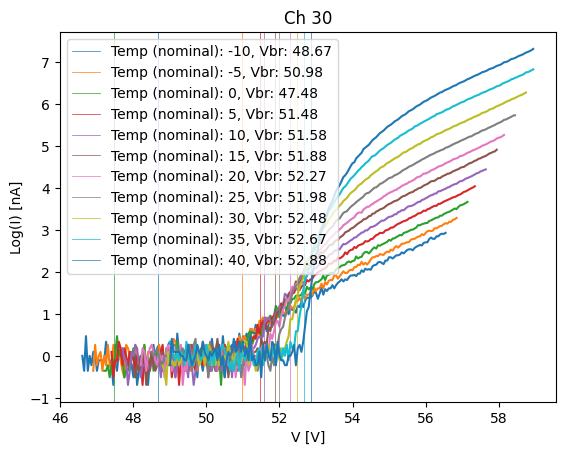

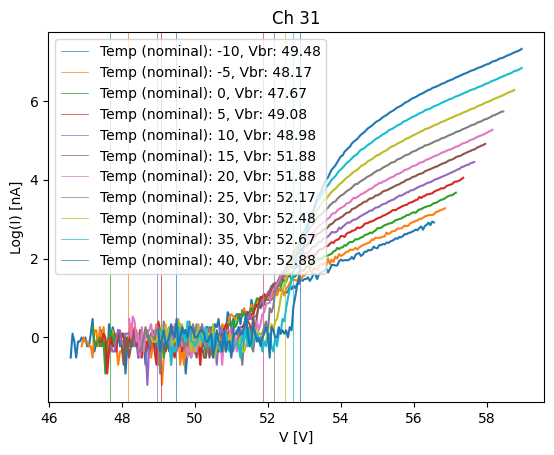

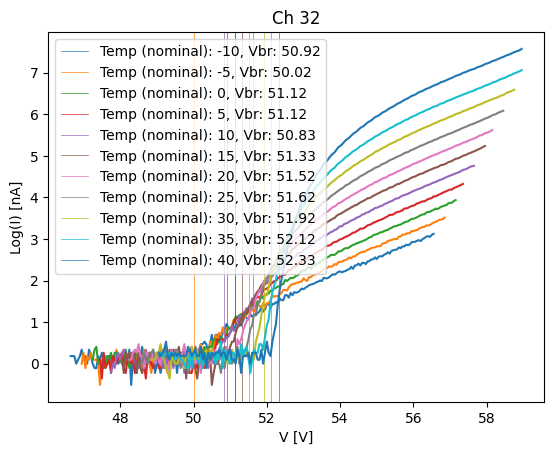

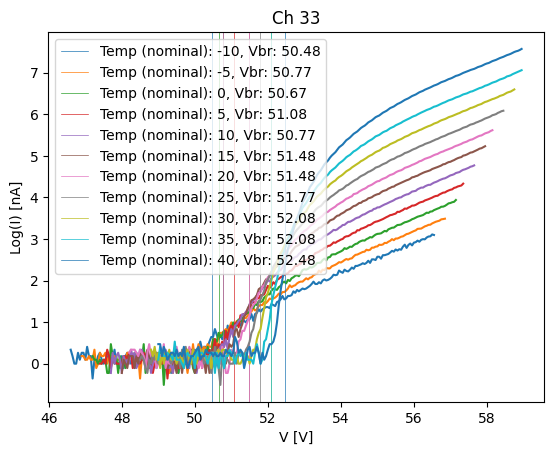

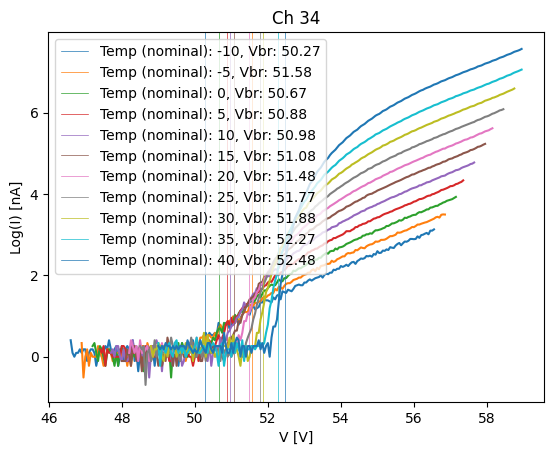

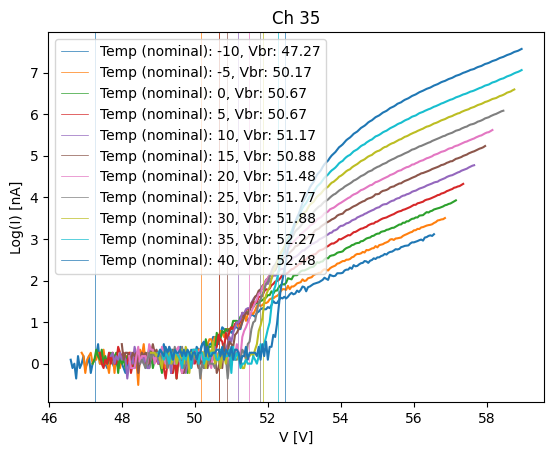

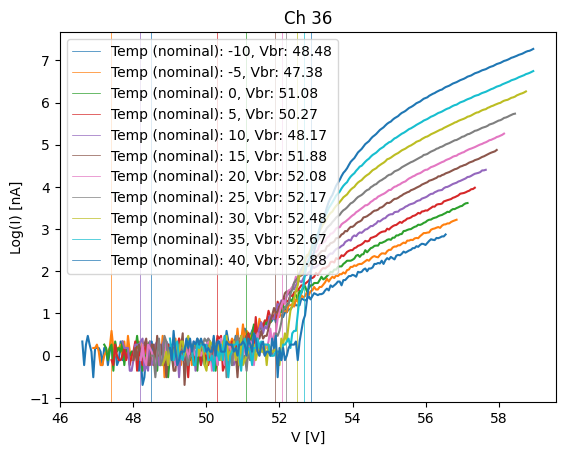

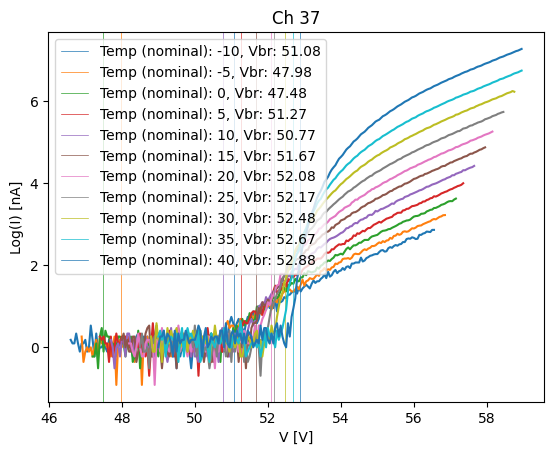

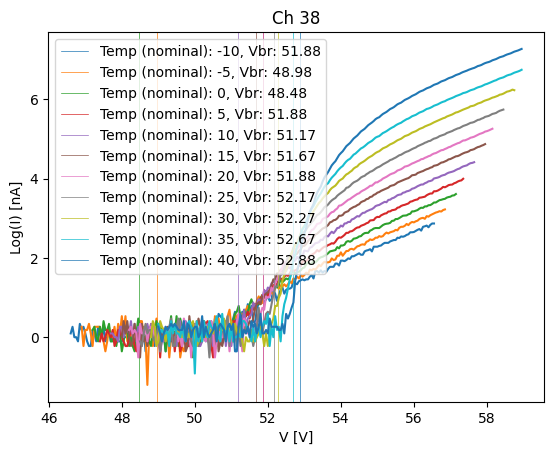

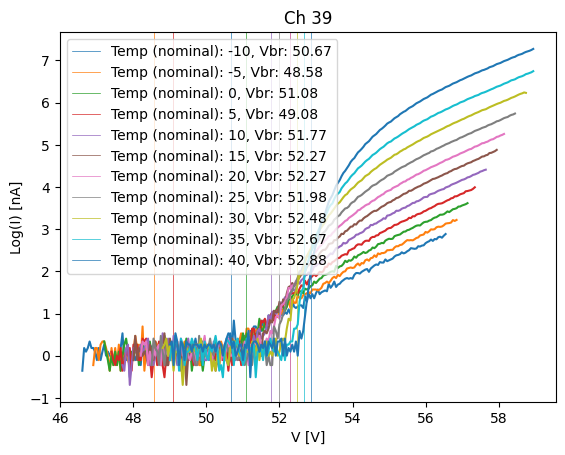

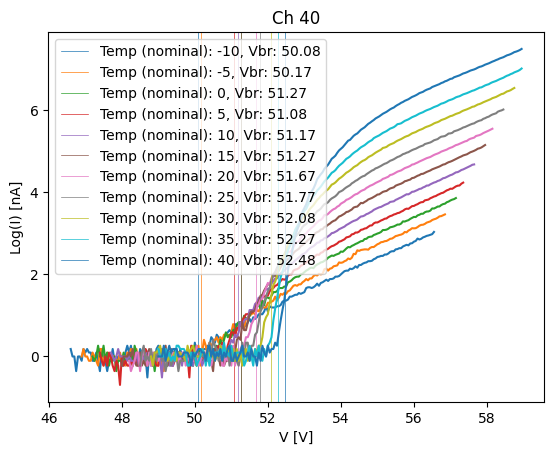

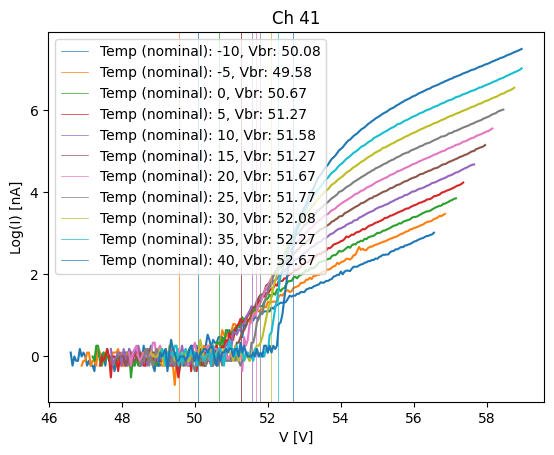

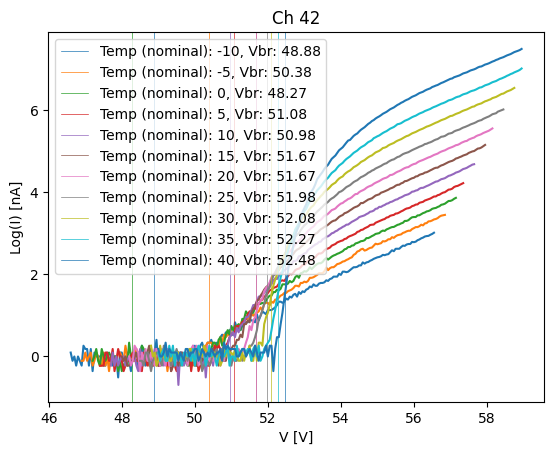

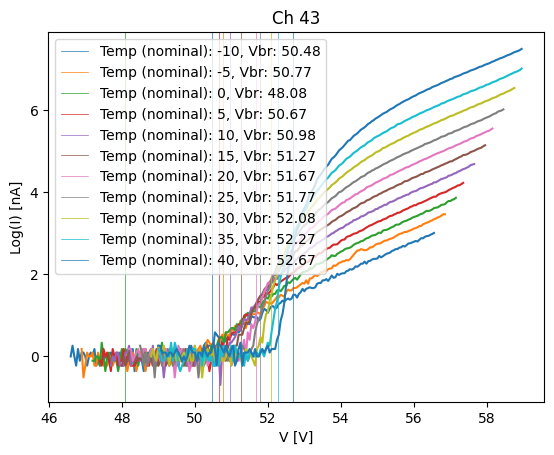

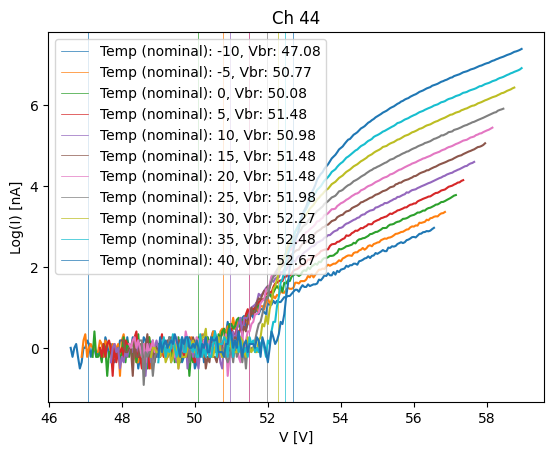

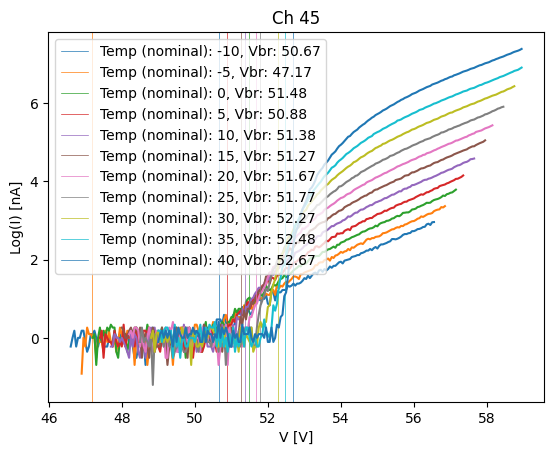

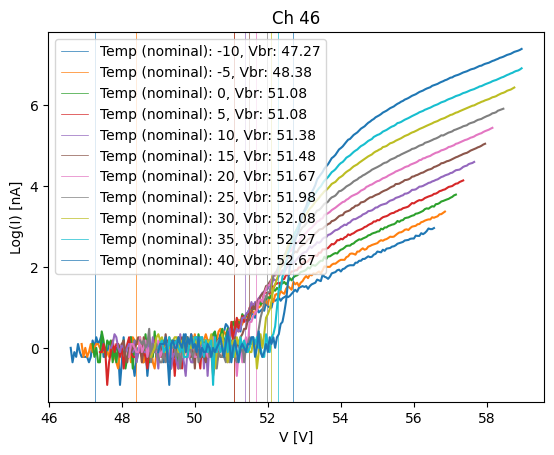

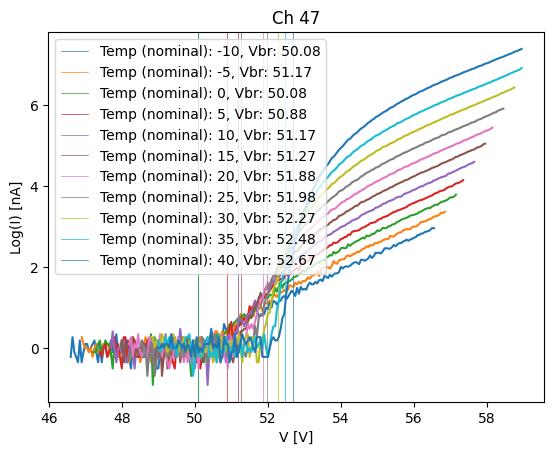

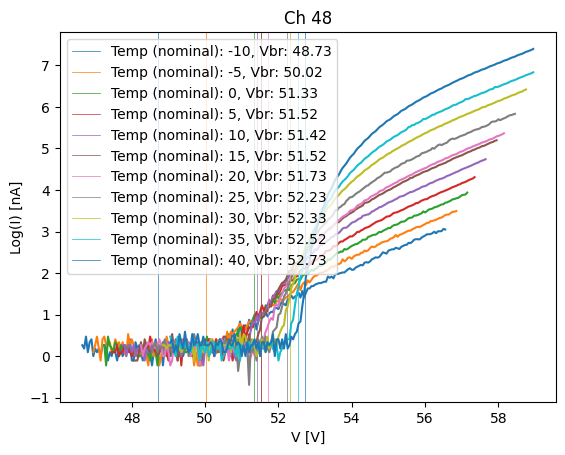

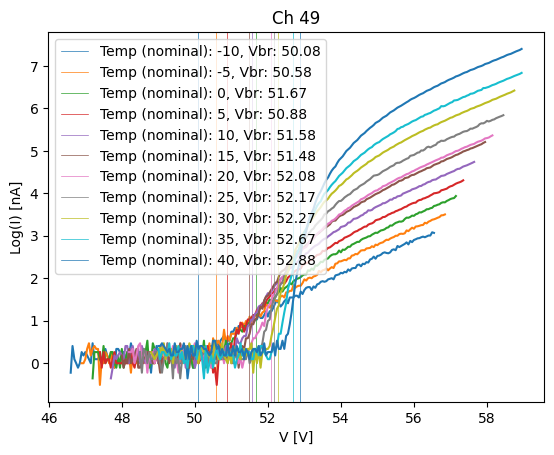

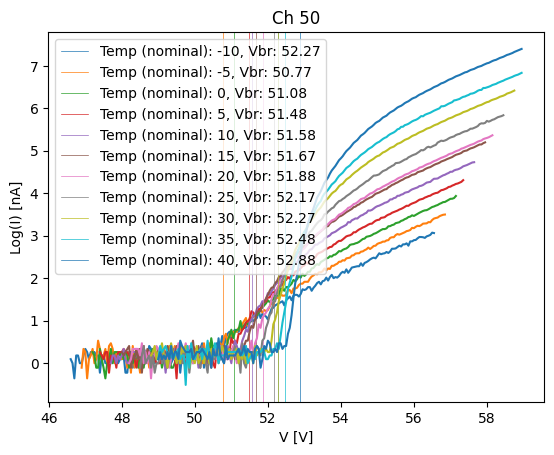

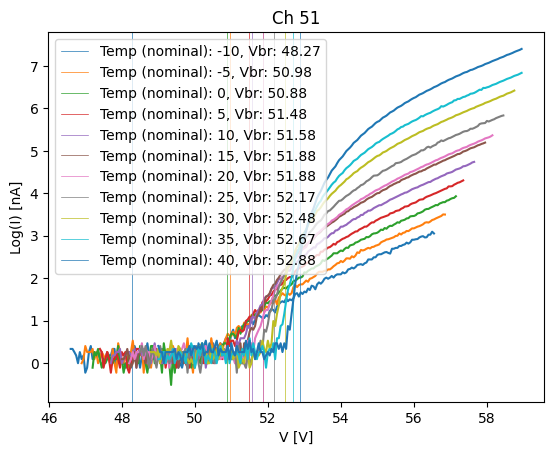

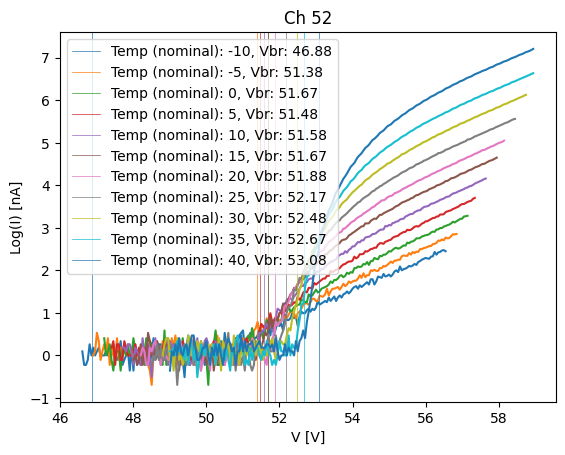

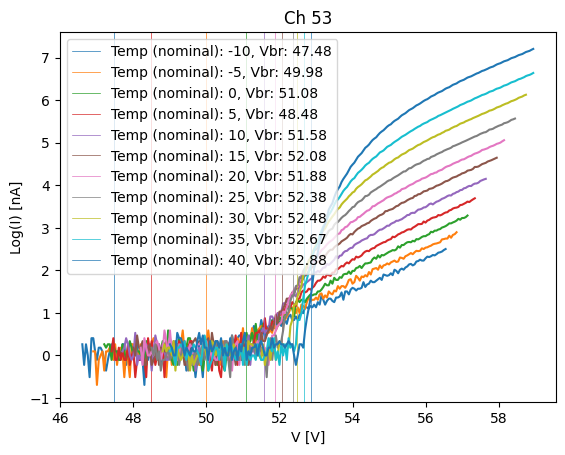

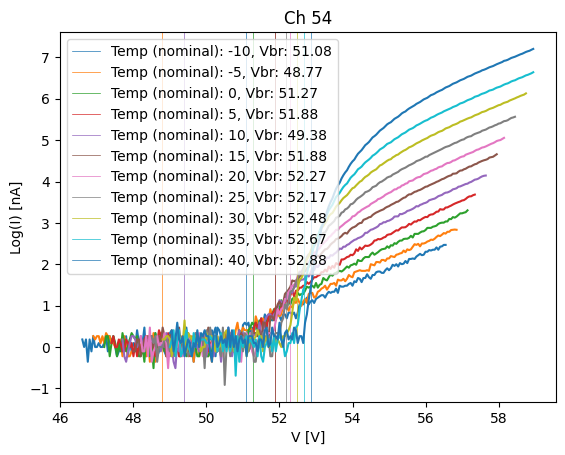

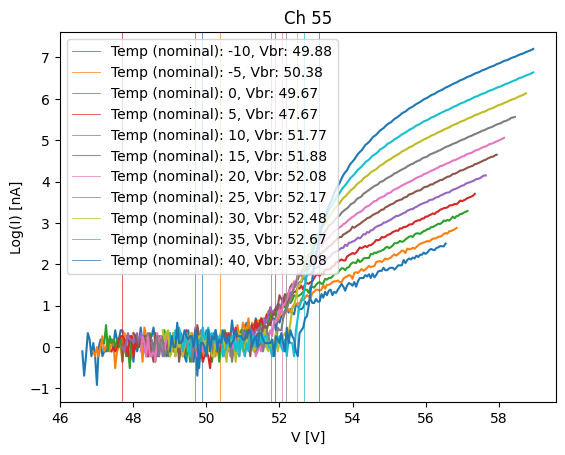

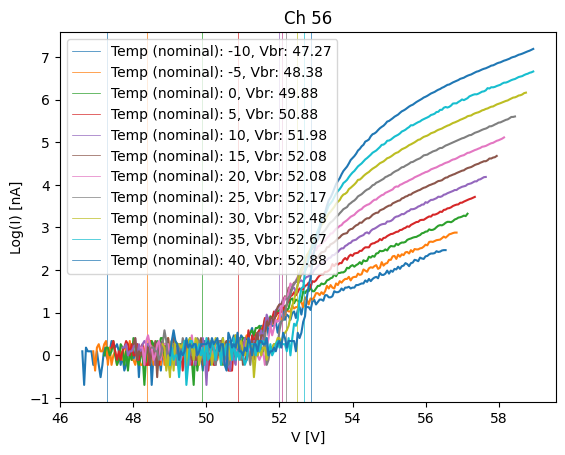

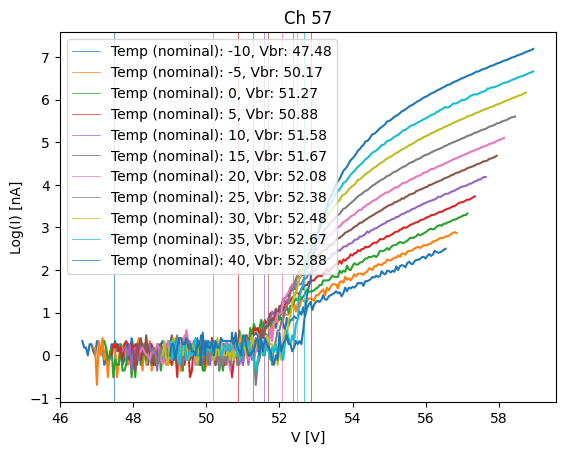

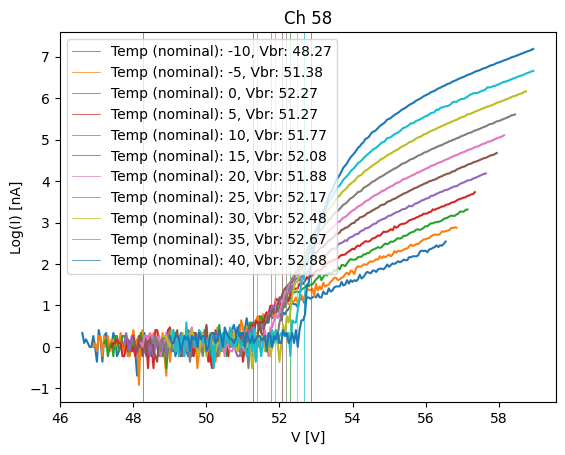

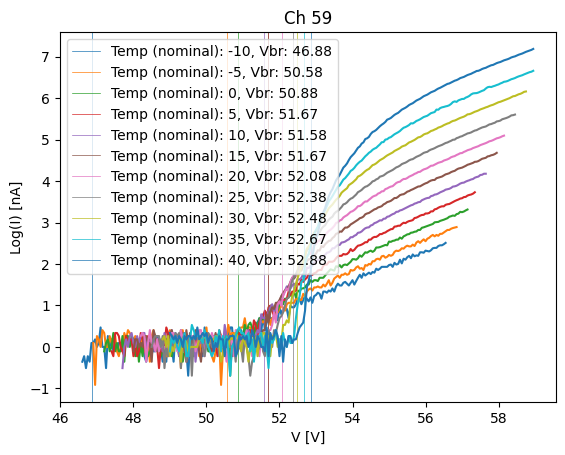

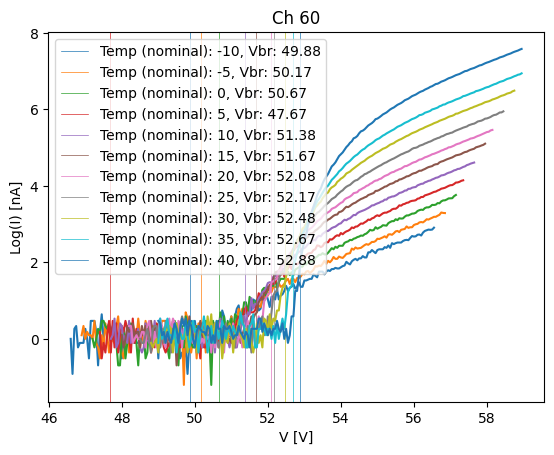

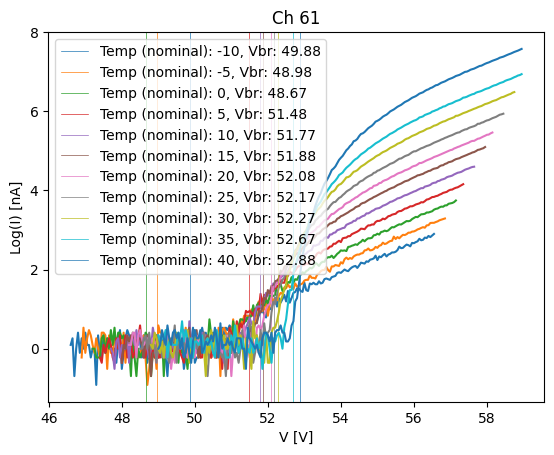

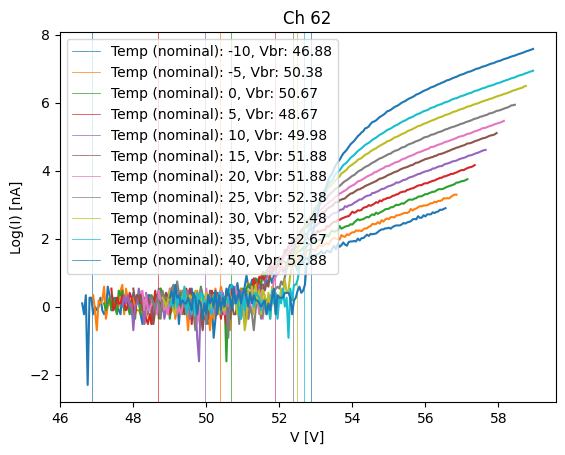

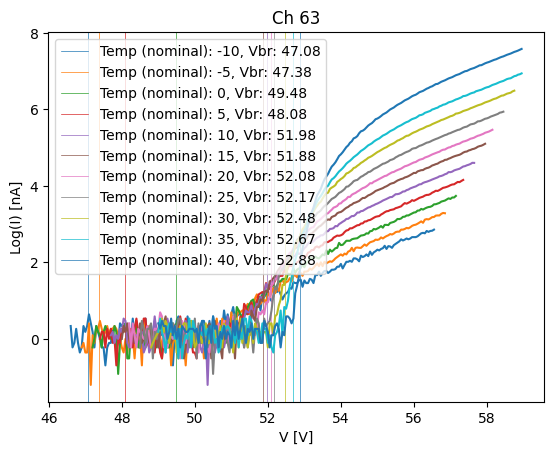

In [7]:
channels = df['chan'].unique()
channels = np.sort(channels)
temps = df['Temp_nominal'].unique()
temps = np.sort(temps)
for chan in channels:
    plt.figure()
    for Temp in temps:
        df2 = df.query('chan==%d & Temp_nominal==%f & subset==0'%(chan, Temp))
        # Vbr = df2['Vbr_fit'].iloc[0]
        Vbr = df2['Vbr'].iloc[0]
           
        plts = plt.plot(df2.V, df2.I_log, '-')
    
        plt.axvline(x=Vbr, linestyle='-', color = plts[0].get_color(), linewidth=0.5,label='Temp (nominal): %d, Vbr: %.2f'%(Temp, Vbr))
        plt.legend()
        plt.title('Ch %i'%chan)
        plt.xlabel('V [V]')    
        plt.ylabel('Log(I) [nA]')